# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Section 6: Vanilla and Variational Autoencoders 


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Hayden Joy, Marios Mattheakis, and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# DO NOT DELETE THIS CELL
# Load useful libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Plotting libraries
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# TensorFlow and tf.keras
import time
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
print(f"Using TensorFlow version: {tf.__version__}")
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import Accuracy
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm

%matplotlib inline

print(f"Using TensorFlow Datasets version: {tfds.__version__}")
print(f"Using TensorFlow AddOns version: {tfa.__version__}")
%run helpers.py
plt.gray() #set colormap to gray 

Using TensorFlow version: 2.4.1
Using TensorFlow Datasets version: 4.2.0
Using TensorFlow AddOns version: 0.12.1


<Figure size 432x288 with 0 Axes>

## Learning Objectives

By the end of this section, you should be able to:
* refresh what we have learned about bayesian methods and variational inference
* refresh understanding about linear and non-linear transformations
* learn how to impliment AE's, VAE's and CVAE's

<a id="contents"></a>

## Notebook Contents

- [Bayesian Review](#bayes)
    - [MCMC](#mcmc) 
    - [Variational Inference](#vinference)
    - [KL divergence](#kl)

- [dimensionality reduction recap](#dimred) #note the connection to vocabulary embeddings
    - [PCA: a linear method](#pca)
    - [TSNE: a non-linear method](#tsne)
    - [manifolds and visualizations](#tsne_viz)
    - [multivariate gaussians](#mgauss)
    
- [**Building our own Python Classes**](#classes)  #what I cannot create I do not understand
    - [__init__](#init)
    - [.call](#call)
    - [super()](#super)
    
 - [**Break Out Room 1**](#BO1)
    - [make your own class](#BO1A) (4 minutes)
    - [conceptual](#BO1B)  (2 minutes) 

- [**Autoencoders**](#recap)
    - [reconstruction loss](#reconstruction)
    - [upsampling](#upsampling) 

- [**Break Out Room 2**](#BO2) (10 minutes)
    - [finish this conv_ae](#BO2)

- [**Variational Autoencoders**](#vae)
    - [motivating examples and gifs](#vae)
    - [The reparameterization trick](#vae)

- [**Conditional Variational Autoencoders**](#cvae)

- [**\[Bonus\]Further reading**](#bonus)
    - [A Pavlos paper on Bayesian Optimization for RC](#bonus)

<a id='jupyterhub'></a>
## Using SEAS Jupyter Hub [^](#contents "Back to Contents")

**PLEASE READ**: [Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/84598/pages/instructions-for-using-seas-jupyterhub?module_item_id=871908)

SEAS and FAS are providing you with a platform in AWS to use for the class (accessible from the 'JupyterHub-GPU' menu link in Canvas). These are AWS p2 instances with a GPU, 10GB of disk space, and 61 GB of RAM,  for faster training for your networks. Most of the libraries such as keras, tensorflow, pandas, etc. are pre-installed. If a library is missing you may install it via the Terminal.

**NOTE : The AWS platform is funded by SEAS and FAS for the purposes of the class. It is not running against your individual credit.**

**NOTE NOTE NOTE: You are not allowed to use it for purposes not related to this course.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

In [3]:
# RUN THIS CELL
import tensorflow as tf
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print(f"\nNumber of replicas: {strategy.num_replicas_in_sync}\n")

devices = tf.config.experimental.get_visible_devices()
print(f"Devices: {devices}\n")
print(f"{tf.config.experimental.list_logical_devices('GPU')}\n")

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}\n")
print(f"All Pysical Devices: {tf.config.list_physical_devices()}")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of replicas: 1

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id='bayes'></a>

### Recap of Bayesian Methods and Variational Inference

Variational Inference according to Cecilia (see her excellent advanced section for the mathmatics behind it): Infering properties of a population by using data analysis on a sample

We don't just want to get point estimates as outputs, we want to get **distributions** as output.

<img src="https://miro.medium.com/max/700/1*w24nX_4NgfY5wS1_maz0oQ.png"> 


Let $\omega$ represent the weights of our network.

We want the posterior but
<font color='red'> 
$$P(data) = \int_{\theta} p(data,\theta)p(\theta)d\theta=\int_{\omega} p(data,\omega)p(\omega)dw$$
is intractable
</font>


Lets expand it:

<font color='red'> 
$$P(data) = \int_{\omega_1} \int_{\omega_2}\int_{\omega_3}...\int_{\omega_n} p(data|\omega_1,\omega_2, \omega_3, ..., \omega_n )d\omega_1d\omega_2d\omega_3...d\omega_n$$
</font>

<a id='mcmc'></a>
### MCMC:

We are guaranteed to converge to the true distribution because of the Detail Balance (beyond the scope of the course but here is a <a href = "https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf"> resource </a>)

$$P(\Theta | data) = P(w | data) \propto P(data | w) P(w)$$

$$\alpha = \frac{\frac{p(\theta^j|y)}{p(y)}}{\frac{p(\theta^{j-1}|y)}{p(y)}} = \frac{p(\theta^j|y)}{p(\theta^{j-1}|y)}=\frac{p(y|\theta^j)p(\theta^j)}{p(y|\theta^{j-1})p(\theta^{j-1})}=\frac{p(\text{posterior at step j})}{p(\text{posterior at step j-1})}$$

If this ratio >1 high then we accept the new point, else flip a "weighted coin" (weight $\alpha$ to reject.

<font color='blue'> Why do we flip the coin with probability? $\alpha$ </font>

visualization of mcmc: https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana

Problems with markov chain monte carlo (convergence time) leads us to approximate the posterior with variational methods.

<a id='vinference'></a>

### Variational inference
Lets approximate the posterior with a friendly (Exponential family) set of distributions.

$p(w|y)\approx q^*(w)$

We do this by minimizing the KL divergence between p and q:

$$q^*(\theta)=argmin_{q \in Q} D_{KL}(p || q) = \int_x log\left( \frac{P(x)}{Q(x)} \right) $$

if we assume a log-normal prior we can write:

$$\mathcal{L} = -0.5 * \frac{1}{n} \sum_{i=1}^n{log(\sigma_i) - \mu_i^2 - \exp(log(\sigma_i)) + 1}$$

We optimize for q

See this <a href = "https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8">resource  </a> for more information about the KL divergence (or Cecilia's great advanced section!)

The KL divergence can also be interpreted as relative entropy (thanks to Chris Gumb for pointing this out):

From wikipedia: "Consider two probability distributions P and Q. Usually, P represents the data, the observations, or a probability distribution precisely measured. Distribution Q represents instead a theory, a model, a description or an approximation of P. The Kullback–Leibler divergence is then interpreted as the average difference of the number of bits required for encoding samples of P using a code optimized for Q rather than one optimized for P."

<img src="https://raw.githubusercontent.com/ssydasheng/FBNN/master/figures/anime-sin-per.gif" >

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Multivariate_normal_sample.svg/1200px-Multivariate_normal_sample.svg.png">

<a id='linear'></a>
## Linear Projections, Non-linear Projections, and Manifolds
<img src="https://i.makeagif.com/media/8-08-2018/alBy82.gif" width=300>

## properties of linear Transformations

$$T(x+y) = T(x) + T(y)$$

$$T(aX) = aT(x)$$

<img src="https://miro.medium.com/max/1400/1*T7CqlFV5aRm6MxO5nJt7Qw.gif">

<a id='pca'></a>
### 1. Principal Component Analysis (1903)
As a reminder, Principal Components analysis is an orthogonal linear transformation that was invented by Karl Pearson and discovered independently by Harold Hoteling in the 1930's.

Important facts

- The principal components are eigenvectors of the data's covariance matrix

Assumptions

- Features are **linearly** correlated

- multi-variate gaussian (check Marios section)

Strengths: 

- Good at performing dimensionality reduction

- Good at finding linear correlations between features

- Eigenvectors are sorted by decreasing eigenvector values

- minimizes information loss

- Variance explained is very interpretable

- spatial dimension information not lost

- reversible

Limitations

- The final two principal components that we keep are just a **projection** from higher dimensional space into lower dimensional space, they are not a true representation of the data as Marios pointed out in section.

- **PCA fails to find non-linear correlations between features**


<img src="https://cdn.britannica.com/32/38832-004-24FF6E46/Karl-Pearson-pencil-drawing-FA-de-Biden-1924.jpg" width = 200>

Facts about Pearson:

- Pearson correlation coefficient

- first use of a histogram

- in 1902 at the Academy of Science Einstein ready Pearson's "The grammer of science" which asserted that the laws of nature are relative to the observer, talked about how an observer traveling at the speed of light would see an "eternel now" and that if they traveled faster than light they would see an eternal now.

- Dark details: eugenicist and anti-semite.

<a id='nonlinear'></a>
## NonLinear Transformation:
<img src="./fig/non-linear-transform.gif">
<img src="./fig/rieman.gif" width=500>

#### Do transformations of features caused by Nueral Networks fall into the linear or non-linear category?

### "Manifold, in mathematics, a generalization and abstraction of the notion of a curved surface; a manifold is a topological space that is modeled closely on Euclidean space locally but may vary widely in global properties."
— https://www.britannica.com/science/manifold

<img src="https://i.imgur.com/gFpAMa3.gif" width=300>

<a id='tsne'></a>
### 1. TSNE (Introduced by Lars Van der Maatin and Geoffrey Hinton in 2008)

T-Distributed Stochastic Neighbor Embedding

Resources:

- How to use TSNE effectively by https://distill.pub/2016/misread-tsne/ by Wattenberg et al from Google

- Harvard MCB 112 final lecture with credit to Sean Eddy: http://mcb112.org/w13/w13-lecture.html
 
- Original <a href="https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">paper by Hinton et al 2008'</a>

<img src="https://preview.redd.it/dsashacpmgp01.png?width=960&crop=smart&auto=webp&s=85a66fc8a0a0ad904b628d88ba54340017b4d553" width = 200>

"T-sne tries to preserve local neighborhood structure from high dimensional space in low dimensional space by converting pairwise distances to pairwise joint distributions. Then using the KL divergence it tries to match the distributions. "

https://towardsdatascience.com/paper-summary-borealisai-automatic-selection-of-t-sne-perplexity-676a49cf2097

"Each data point is given an ordered preference for a relatively small number of neighbors in the original space. In the so-called "embedded space" (in the two-dimensional t-SNE plot), the points are arranged to preserve that preference and order." —MCB112 Harvard University

Characteristics:

- Non-linear transformation

- "t-SNE cares about preserving neighbor relations, not absolute distances"

- very sensitive to hyper-parameters (perplexity especially)

Strengths

- well suited for embedding high dimensional space in a 2 or 3 dimensional space

- Captures non-linear transformations

- minimize the KL divergence between distributions over the high dimensional space and a probability distribution over the lower dimensional manifold

- points tend not to crowd together

Weaknesses

- irreversible

- distance between points is relative (original spatial information is lost)

- absolute distances within clusters and between cannot be interpreted

- Generally you need to do some dimensionality reduction (if dim >50) via an auto-encoder or PCA **before** you can submit information to TSNE

<a id='tsne_viz'></a>

<img src="https://miro.medium.com/max/1000/1*a39T3o9QDA6lgj-R1NKo-Q.gif">

<img src="https://miro.medium.com/max/1948/1*hUkKaOOFau8XNIU-lZublw.gif" width=300 > 

<img src="http://fastforwardlabs.github.io/blog-images/miriam/160805_1646_train_16.0.col256_qual100_del11_nodith.gif">


<a id='classes'></a>

## Python Classes

### "What I cannot create I do not understand"

***We've seen these before!***

0. Python as an Object Oriented Programming languange (OOP)

In this <a href='https://realpython.com/python3-object-oriented-programming/"article'> real python article </a> the authors write classes bundle related properties and behaviours into individual objects. 
1. Methods and Attributes

- Functions of a class are known as **methods**

- variables of a class are known as **attributes**

2. Classes vs Instances

- "A class is like a blueprint for how something should be defined and doesn't actually contain data".

- "An instance is an object that is built from a class and contains real data."

3. *\__ init \__*( ) method

- the init method initializes class instances with properties as defined in the class.
    Specifically it sets **instance attributes**, not **class attributes**. It sets the **initial state** of the object by assigning the object's initial state.
    
For example I might have a **general** tiger class which contains attributes such as fang length, name and color.

In [4]:
class Tiger: #by convention classes are capitalized
    
    #instance attributes are defined in the init method
    def __init__(self, name, age, color, fang_length):
    
        self.age = age
        self.name = name
        self.color = color
        self.fang_length = fang_length
        
    # Instance methods:
    ##################################################
    def description(self):
        print(f"{self.name} is {self.age} months old")

    def rawr(self, pedestrian):
        return f"{self.name} Rawrs at {pedestrian}"
    ####################################################

In [5]:
specific_tiger = Tiger(name = "Little Johnny", age = 5, color = "red", fang_length = 0.05)

specific_tiger.description()
print(specific_tiger.rawr("Bill"))

Little Johnny is 5 months old
Little Johnny Rawrs at Bill


<a id='call'></a>
3. **\__ call \__() method**

- The call method allows us to treat our class instances as functions. This will be vitally important for homework 7 because you will be creating custom keras layers that need to inherit from layers.Layer.

4. Inheritance
Definition: Inheritance is a concept where a class inherits attributes and methods from a super-class without needing to impliment them again.

- The super method allows us to call methods and attributes of the super-class that we are inheriting from.

In [6]:
class Sumatra_Tiger(Tiger): #by convention classes are capitalized
    
    #class attributes are defined directly below the definition
    #class attributes have the same value for all class instances of this type
    species = "Panthera tigris sumatrae" 
    
    #instance attributes are defined in the init method
    def __init__(self, name, age, color, fang_length):
        super().__init__(name, age, color, fang_length)
        self.action_dict = dict(zip([1,2,3], 
                                    [f"bit a pedestrian with her {self.fang_length} inch fangs", 
                                     "went swimming", 
                                     "lounged in the sun"]))
    
    def __call__(self):
        action_key = np.random.choice([1,2,3])
        print(self.name, self.action_dict[action_key])

In [7]:
#declare the class instance
sara = Sumatra_Tiger(name = "little_sara", age = 1, color = "red", fang_length = 0.05)

#let's use the call method
for i in range(3):
    sara()
print(f'Tiger: {sara.name} \n Species: {Sumatra_Tiger.species} \n color: {specific_tiger.color}')

little_sara lounged in the sun
little_sara bit a pedestrian with her 0.05 inch fangs
little_sara went swimming
Tiger: little_sara 
 Species: Panthera tigris sumatrae 
 color: red


<a id='bo1'></a>
## Breakout Room 1
Your tasks in this first breakout room are as follows:
1) impliment the analytical kl divergence as a class. It should take Lambda as an argument (which is a hyper-parameter that determines the strength of the kl_divergence in a loss function). Use the \__init__(self) method to assign this value to self. Next, impliment the call method so that when this class is called it calculates the kl divergence of the given mean and log variance.

2) answer the follow up question


From Pavlos's exercise Variational Auto-Encoder from scratch:
### Log space and the  Log Normal PDF
We will be using log loss. This is because it is numerically more stable. 


$$f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$$

$$ \log f(x)=  -\log(\sigma) -\frac{1}{2} \left(\log(2 \pi) -(\frac{x-\mu}{\sigma})^2)\right)$$



### KL Divergence Analytical form
We will use this analytical form to compute the KL divergence

$\mathrm{KL} [ q_{\phi}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) ]
= - \frac{1}{2} \sum_{k=1}^K { 1 + \log \sigma_k^2 - \mu_k^2 - \sigma_k^2 }$

where $K$ is the number of hidden dimensions. 


In [8]:
def analytical_kl(mu, logvariance, Lambda = 0.1):
    mean, logvariance = args
    # tf.reduce_sum is over the hidden dimensions
    lossval = Lambda * np.sum(-0.5*(1 + logvariance - mu**2 - logvariance),axis=-1)
    return tf.reduce_mean(lossval)

In [9]:
#exercise
class analytical_kl:
    ...

In [10]:
#solution
class Analytical_KL:
    def __init__(self, Lambda):
        self.Lambda = Lambda
    def __call__(self, mu, logvariance):
        lossval = self.Lambda * np.sum(-0.5*(1 + logvariance - mu**2 - logvariance),axis=-1)
        return lossval 


In [11]:
kl = Analytical_KL(Lambda = 0.1)
kl(0,1)

-0.5

#### What is the range of the KL Divergence? ie what are the minimum and maximum values it can take on?

#### How does the KL Divergence scale? With respect to what hyper-parameter in the context of a convolutional auto-encoder?

<a id='recap'></a>

# Recaping Auto-encoders

<a id='reconstruction'></a>
<img src="./fig/bottle_neck_img.png">

## Reconstruction loss:
*Mean squared Error*

$\mathcal{L}_{p}=-\frac{1}{N}\sum_{i=1}^{N} \left[  \sum_j \left(  y_{ij} -\hat{y}_{ij}\right)^2 \right] $

where $\hat{y}_i$ is the output of the NN, $y_i$ is the true label, and  $N$ is the number of images and $j$ represents the pixel index. 

<a id='upsample'></a>
## Upsampling — lets keep it simple:

<img src="https://kharshit.github.io/img/upsampling1.png">

If you'd like to read about other more complicated methods please see the resource below:

https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0

### <font color='red'> How does the reconstruction loss scale? </font>

## We will again be using a dataset from cycle_gan like in section2, this time we will be looking at Van Goh!

In [12]:
(trainA, trainB, testA, testB), ds_info = tfds.load('cycle_gan/vangogh2photo', 
                                         split = ["trainA", "trainB", "testA", "testB"], 
                                         shuffle_files=True, as_supervised=True, with_info=True)

MODELS_TRAINED = True

In [13]:
print(f' Dataset cardinality: Art train {int(trainA.cardinality())} images, pic train {int(trainA.cardinality())} images.')
print(f'                      Art test {int(testA.cardinality())} images, pic test {int(testB.cardinality())} images.')

 Dataset cardinality: Art train 400 images, pic train 400 images.
                      Art test 400 images, pic test 751 images.


image size:  (256, 256, 3)


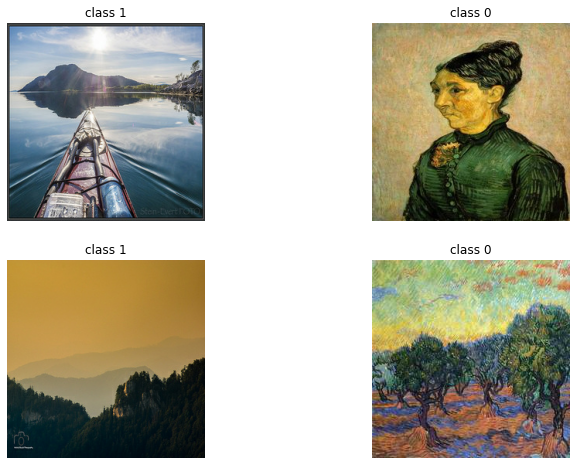

In [14]:
def display_imgs(tfds1, tfds2):
    """
    A helper function that displays a four images from the horse2zebra cycle gan dataset, two for each class.
    """
    fig, ax = plt.subplots(2,2, figsize = (12, 8)); ax = ax.flatten()

    horse_imgs, zebra_imgs = [], []
    for i, (image, label) in enumerate(tfds1.shuffle(buffer_size = 2).take(2)):
        plt.sca(ax[2*i + 1])
        plt.imshow(image)
        plt.title(f"class {label}")
        plt.axis('off')
        horse_imgs.append(image)

    for i, (image, label) in enumerate(tfds2.shuffle(buffer_size = 2).take(2)):
        #plt.sca() switches the current pyplot
        plt.sca(ax[(i - 1) * 2])
        plt.imshow(image, cmap = "twilight_r")
        plt.title(f"class {label}")
        plt.axis('off')
        zebra_imgs.append(image)
    print('image size: ', image.shape)
    
    return horse_imgs, zebra_imgs
monet_imgs, real_imgs = display_imgs(trainA, trainB)

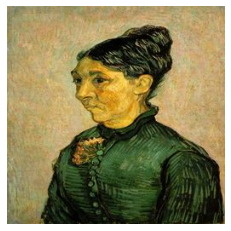

In [15]:
plt.imshow(next(iter(trainA))[0]); plt.axis('off');

### Preprocess the data

In [16]:
ds_train = trainA.concatenate(trainB)
ds_test  = testA.concatenate(testB)

H = W = 256//2
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalize_img(img, label):
    return tf.cast(img, tf.float32)/255.0, label

def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label

def preprocess(tfds_):
    return tfds_.map(normalize_img, num_parallel_calls=AUTOTUNE).map(resize_img, AUTOTUNE)

ds_train = preprocess(ds_train)
ds_test = preprocess(ds_test)
artTrain, picTrain = preprocess(trainA), preprocess(trainB)
artTest, picTest = preprocess(testA), preprocess(testB)


In [17]:
#making the validation sets
ds_test = ds_test.skip(500)
ds_val = ds_test.take(500)
f'val size {ds_val.cardinality().numpy()},  {ds_test.cardinality().numpy()}'

'val size 500,  651'

In [18]:
#making the validation sets
artVal = artTest.skip(100)
artTest = artTest.take(100)
artTest.cardinality(), artVal.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=100>,
 <tf.Tensor: shape=(), dtype=int64, numpy=300>)

In [19]:
picVal = picTest.skip(350)
picTest = picTest.take(350)
picTest.cardinality(), picVal.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=350>,
 <tf.Tensor: shape=(), dtype=int64, numpy=401>)

In [20]:
def add_noise(x, label, sigma=0.1, reshape = False):
    x = tf.cast(x, dtype = tf.float32)
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)
    noise_img = tf.add(x, noise)
    #assert False
    if reshape:
        x = tf.reshape(x, shape = (128*128*3,))
        noise_img = tf.reshape(noise_img, shape = (128*128*3,))
    
    return noise_img, x

def plot_prep(img, reshape = True):
    img = tf.cast(img * 255, dtype = tf.int32)
    img = tf.clip_by_value(img, 0 , 255)
    img = tf.expand_dims(img, axis = 0)
    return img.numpy()

art_ae_train = artTrain.map(add_noise)
art_ae_val = artVal.map(add_noise)
art_ae_test = artTest.map(add_noise)

pic_ae_train = picTrain.map(add_noise)
pic_ae_val  = picVal.map(add_noise)
pic_ae_test = picTest.map(add_noise)

## An example of custom keras layers:

(for more information on super see <a href = "https://www.programiz.com/python-programming/methods/built-in/super#:~:text=The%20super()%20builtin%20returns,Working%20with%20Multiple%20Inheritance">this post: </a>

In [21]:
class FFN_encoder(Layer):
    """
    A fully connected encoder for an AE.
    """
    def __init__(self, activation, input_shape, embedded_dimension, **kwargs):
        #super in combination with **kwargs 
        #here allows keras to pass arguments to the class.
        super(FFN_encoder, self).__init__(name = "encoder", 
                                          input_shape = input_shape, **kwargs)
        act = {"activation" : activation}
        self.model = Sequential([
                    #Flatten(),
                    Dense(2**4, **act),
                    Dropout(0.1),
                    Dense(embedded_dimension[0], activation = "linear")])
    def __call__(self, inputs,  training=None):
        m = self.model(inputs, training = training)
        return m
    
class FFN_decoder(Layer):
    """
    A fully connected dencoder for an AE.
    """
    def __init__(self, activation, input_shape, output_shape, **kwargs):
        super(FFN_decoder, self).__init__(name = "decoder", 
                                         input_shape = input_shape, **kwargs)
        print('output_dim', output_shape)
        act = {"activation" : activation}
        self.model = Sequential([
                    Input(shape = input_shape),
                    Dropout(0.1),
                    Dense(2**4, **act), 
                    Dense(output_shape, activation = "sigmoid"),
                    ])
    def __call__(self, inputs,  training=None):
        m = self.model(inputs, training = training)
        return m
#we have pictures

In [22]:
INPUT_SIZE = (128*128*3,)
BOTTLENECK_DIM = (4,)
BATCH_SIZE = 64

encoder = FFN_encoder("relu", input_shape = INPUT_SIZE, embedded_dimension = BOTTLENECK_DIM )
decoder = FFN_decoder("relu", input_shape = BOTTLENECK_DIM, output_shape = INPUT_SIZE[0])

_input = Input(shape = INPUT_SIZE)

output = decoder(encoder(_input))

FFN_AE = models.Model(inputs = _input, outputs = output)
        
FFN_AE.compile(optimizer = 'adam', loss = losses.MeanSquaredError())
FFN_AE.summary()

output_dim 49152
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49152)]           0         
_________________________________________________________________
sequential (Sequential)      (None, 4)                 786516    
_________________________________________________________________
sequential_1 (Sequential)    (None, 49152)             835664    
Total params: 1,622,180
Trainable params: 1,622,180
Non-trainable params: 0
_________________________________________________________________


In [23]:
EPOCHS = 100
DATA_DIR = 'data/'
MODELS_TRAINED = True

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#mc = ModelCheckpoint(DATA_DIR + "cnn1/cp.ckpt", monitor='val_loss', save_best_only=True, save_weights_only=False)

if not MODELS_TRAINED:
    history = FFN_AE.fit(ds_train_noisy.shuffle(buffer_size = ds_train_noisy.cardinality()).batch(BATCH_SIZE),#.prefetch(AUTOTUNE),
                        validation_data=ds_test_noisy.batch(BATCH_SIZE),#.prefetch(AUTOTUNE),
                        epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    model.save(DATA_DIR + 'FFN_AE')
else:
    #load the model
    FFN_AE = tf.keras.models.load_model(DATA_DIR + 'FFN_AE')

    # Check its architecture
    FFN_AE.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49152)]           0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 1573160   
_________________________________________________________________
sequential_1 (Sequential)    (None, 49152)             1622304   
Total params: 3,195,464
Trainable params: 3,195,464
Non-trainable params: 0
_________________________________________________________________


### <font color='red'> How can we turn the above auto-encoder into PCA? </font>

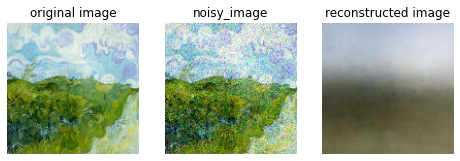

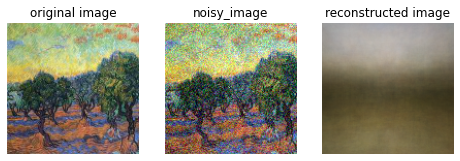

In [24]:
def display_images(ds, n_imgs = 3, model = None):
    n = n_imgs
    for noisy_img, img in ds.take(n):
        m = 3 if model else 2
        fig, ax = plt.subplots(1, m, figsize = (8,4))
        ax[0].imshow(plot_prep(img).reshape(-1,H,3))
        ax[1].imshow(plot_prep(noisy_img).reshape(-1,H,3))
        
        if model:
            
            try:
                #if the model is convolutional then this case will execute
                img4d = tf.expand_dims(noisy_img, axis = 0)
                reconstructed_img = model.predict(img4d)
            except:
                #otherwise this case will execute
                noisy_img = tf.reshape(noisy_img, shape = (128*128*3,))

                img2d = tf.expand_dims(noisy_img, axis = 0)
                reconstructed_img = model.predict(img2d)
            
            reconstructed_img = tf.reshape(reconstructed_img, shape = (128,128,3))
            
            ax[2].imshow(reconstructed_img)

        titles = ["original image", 'noisy_image', 'reconstructed image']

        [ax[i].set_title(title) for i, title in enumerate(titles)]

        [ax[i].axis('off') for i in range(m)]

        plt.show()
display_images(ds = art_ae_train, n_imgs = 2, model = FFN_AE  )

Why didn't that work very well?

<a id='BO2'></a>

## Break Out Room 2

Complete the following make_convAE (convolutional Auto-encoder) function.

<img src="https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png" width = 550>

In [25]:
#complete the following convolutional auto-encoder code and start training.

def make_ConvAE(activation, input_dim, embed_dim):
    """
    A convolutional auto-encoder encoder for an AE.
    This model is very large, you will likely want to design something smaller for the hw.
    
    Parameters
    ----------
        activation: string
            the activation function to use in the encoding
        input_shape: int tuple ex (128, 128, 3)
            the input shape of the image
        embed_dim: 
            the dimension of the embedding layer
        
    """
    act_down = {"activation" : activation, "strides": (2,2), 'padding' : 'SAME' }

    act_up = {"activation" : 'relu', 
              'kernel_size': ...,    #kernel size for the upsampling convolution layers
              "strides": ..., 
              'padding' : ... }
    upsamp_args = {'size' : (2,2), 'interpolation' : 'nearest'}

    flat_embed_dim = (..., ) #take the product of the embedded dimension shape

    encoder = Sequential([
                Conv2D(2**4, kernel_size = (3,3), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(2**5,  kernel_size = (2,2), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(2**5, kernel_size = (2,2), **act_down),  #64/2 ->32
                Dropout(0.05),
                ...,
                
                Dense(flat_embed_dim[0], activation = ...), #begin embedding space
                Dense(flat_embed_dim[0], activation = ...),   #end embedding space
                
                layers.Reshape(embed_dim)])
    decoder =  Sequential([
                Input(shape = embed_dim),
                
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**5, **act_up),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**4, **act_up), 
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**3, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(2**2, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(3, activation = ..., 
                             kernel_size = (1,1), 
                             strides = (1,1),
                             padding = ...),
                ])
    _input = Input(shape = INPUT_SIZE)


    output = ...

    conv_AE = models.Model(inputs = _input, outputs = output)

    conv_AE.compile(optimizer = Adam(learning_rate=1e-4), loss = ...)
    conv_AE.summary()
    
    return conv_AE

MODELS_TRAINED = False
BATCH_SIZE = 256
EPOCHS = 10
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

HIDDEN_DIM = (4, 4, 64)
INPUT_SIZE = (H,W,3)

conv_ae = make_ConvAE( activation = 'relu',
            input_dim = INPUT_SIZE, 
             embed_dim = HIDDEN_DIM) #BOTTLENECK_DIM is the product of this

history = conv_ae.fit(art_ae_train.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                      validation_data = art_ae_val.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                      epochs=EPOCHS, callbacks = [es]
    )
plot_loss(history)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'ellipsis'

In [26]:
# %load sol/bo2_sol.py
# Crucially, observe that we sum across the image dimensions and only take the mean in the 
# images dimension
def reconstruction_loss(y_target, y_predicted):
    loss = tf.keras.losses.mean_squared_error(y_target, y_predicted)
    # tf.reduce_sum is over all pixels and tf.reduce_mean is over all images
    return tf.reduce_mean(tf.reduce_sum(loss,axis=[1,2])) 
def make_ConvAE(activation, input_dim, embed_dim):
    """
    A convolutional auto-encoder encoder for an AE.
    
    Parameters
    ----------
        activation: string
            the activation function to use in the encoding
        input_shape: int tuple ex (128, 128, 3)
            the input shape of the image
        embed_dim:
        
    """
    act_down = {"activation" : activation, "strides": (2,2), 'padding' : 'SAME' }
    act_up = {"activation" : 'relu',
              'kernel_size': (4,4),
              "strides": (1,1),
              'padding' : 'SAME' }
    upsamp_args = {'size' : (2,2), 'interpolation' : 'nearest'}
    flat_embed_dim = (np.prod(embed_dim),)
    encoder = Sequential([
                Conv2D(2**4, kernel_size = (3,3), input_shape = input_dim, **act_down), 

                Conv2D(2**5, kernel_size = (2,2), input_shape = input_dim, **act_down),

                Conv2D(2**5, kernel_size = (2,2), **act_down), 
                Dropout(0.05),
                Flatten(),
                
                Dense(flat_embed_dim[0], activation = "linear"), #begin embedding space
                Dense(flat_embed_dim[0], activation = "relu"), #end embedding space
                
                layers.Reshape(embed_dim)])
    decoder = Sequential([
                Input(shape = embed_dim),
                
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**5, **act_up),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**4, **act_up),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(2**3, **act_up),
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(2**2, **act_up),
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(3, activation = "sigmoid",
                             kernel_size = (1,1),
                             strides = (1,1),
                             padding = "SAME"),
                ])
    _input = Input(shape = INPUT_SIZE)
    output = decoder(encoder(_input))
    conv_AE = models.Model(inputs = _input, outputs = output)
    conv_AE.compile(optimizer = Adam(learning_rate=1e-4), loss = reconstruction_loss)
    conv_AE.summary()
    
    return conv_AE


In [27]:
HIDDEN_DIM = (4, 4, 64)
INPUT_SIZE = (H,W,3)

conv_ae = make_ConvAE( activation = 'relu',
            input_dim = INPUT_SIZE, 
             embed_dim = HIDDEN_DIM) #BOTTLENECK_DIM is the product of this

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 4, 4, 64)          9445888   
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 128, 3)       43595     
Total params: 9,489,483
Trainable params: 9,489,483
Non-trainable params: 0
_________________________________________________________________


In [28]:
MODELS_TRAINED = True
BATCH_SIZE = 256
EPOCHS = 1000
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

if not MODELS_TRAINED:
    history = conv_ae.fit(art_ae_train.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          validation_data = art_ae_val.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    conv_ae.save(DATA_DIR + 'conv_ae_noise')
else:
    #load the model
    conv_ae = tf.keras.models.load_model(DATA_DIR + 'conv_ae_noise')

    # Check its architecture
    FFN_AE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49152)]           0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 1573160   
_________________________________________________________________
sequential_1 (Sequential)    (None, 49152)             1622304   
Total params: 3,195,464
Trainable params: 3,195,464
Non-trainable params: 0
_________________________________________________________________


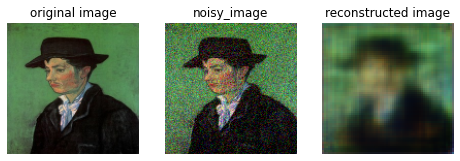

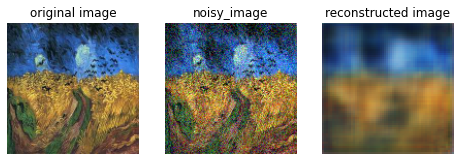

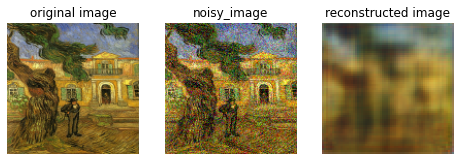

In [29]:
display_images(ds = art_ae_test, n_imgs = 3, model = conv_ae )

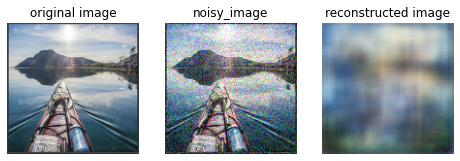

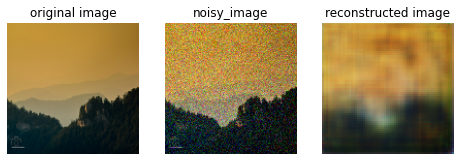

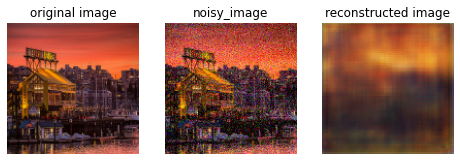

In [30]:
display_images(ds = pic_ae_train, n_imgs = 3, model = conv_ae  )

In [31]:
HIDDEN_DIM = (4, 4, 64)
INPUT_SIZE = (H,W,3)

conv_ae2 = make_ConvAE( activation = 'relu',
            input_dim = INPUT_SIZE, 
             embed_dim = HIDDEN_DIM) #BOTTLENECK_DIM is the product of this

MODELS_TRAINED = True
BATCH_SIZE = 512
EPOCHS = 300
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

if not MODELS_TRAINED:
    history = conv_ae2.fit(pic_ae_train.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          validation_data = pic_ae_val.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    conv_ae2.save(DATA_DIR + 'conv_ae4')
else:
    #load the model
    conv_ae2 = tf.keras.models.load_model(DATA_DIR + 'conv_ae4')

    # Check its architecture
    conv_ae2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 4, 4, 64)          9445888   
_________________________________________________________________
sequential_5 (Sequential)    (None, 128, 128, 3)       43595     
Total params: 9,489,483
Trainable params: 9,489,483
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 4, 4, 64)          17841120  
________________________________

(128, 128, 3)


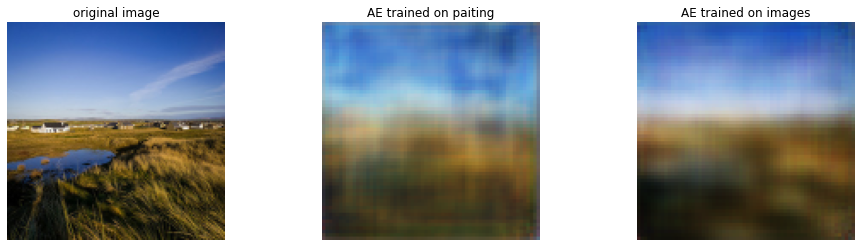

(128, 128, 3)


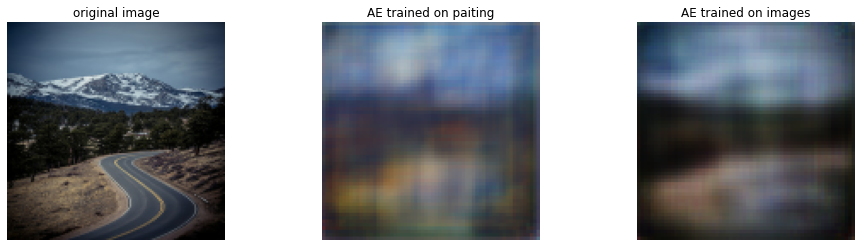

(128, 128, 3)


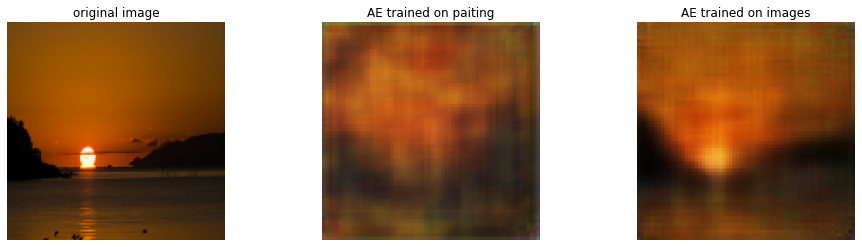

(128, 128, 3)


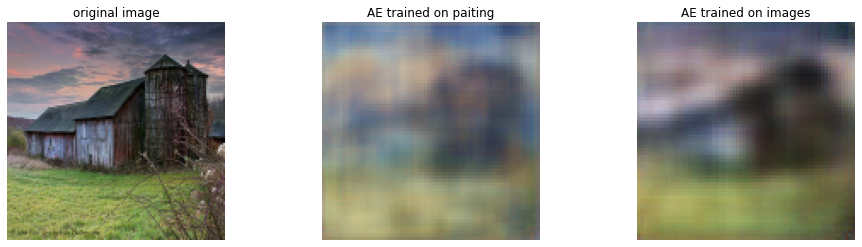

(128, 128, 3)


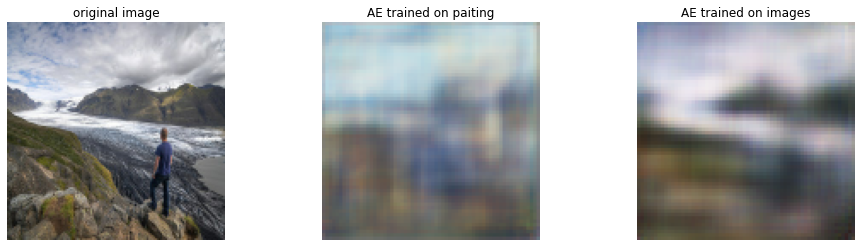

(128, 128, 3)


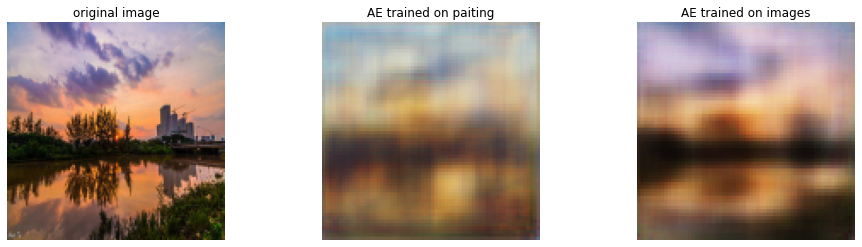

(128, 128, 3)


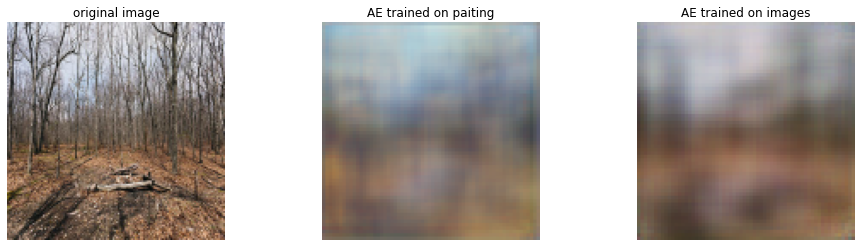

(128, 128, 3)


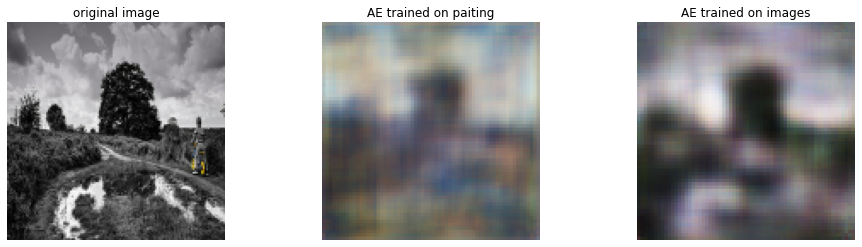

(128, 128, 3)


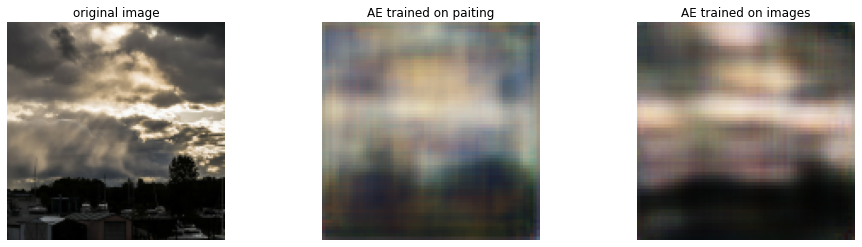

(128, 128, 3)


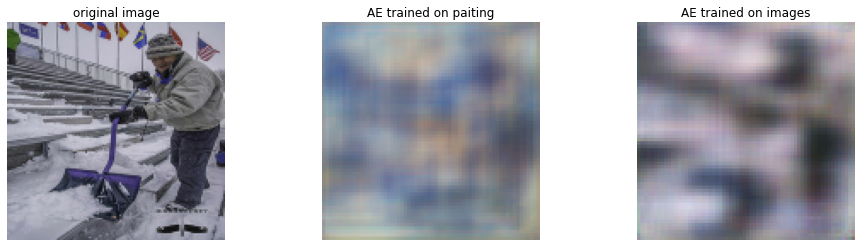

In [32]:
for noisy_img, original_img in picTest.take(10):
    fig, ax = plt.subplots(1,3, figsize = (16,4))
    print(noisy_img.shape)
    #\ax[0].imshow(original_img.numpy().reshape(-1,H,3))
    ax[0].imshow(noisy_img.numpy().reshape(-1,H,3))
    ax[1].imshow(conv_ae.predict(tf.expand_dims(noisy_img, axis = 0)).reshape(-1,H,3))
    ax[2].imshow(conv_ae2.predict(tf.expand_dims(noisy_img, axis = 0)).reshape(-1,H,3))
    titles = ["original image", 'AE trained on paiting', 'AE trained on images']
    
    [ax[i].set_title(titles[i]) for i in range(3)]
    
    [ax[i].axis('off') for i in range(3)]
    
    plt.show()

<a id='vae'></a>

<img src = "https://miro.medium.com/max/3200/0*vzcMMuxlsGhtoySv">

### Variational Autoencoders



<img src="https://miro.medium.com/max/3096/1*Q5dogodt3wzKKktE0v3dMQ@2x.png">

<img src="https://miro.medium.com/max/2098/1*ZlzFeen0J7Ize__drfbwOQ.png">




regularization 

<img src="https://nicola-decao.github.io/assets/img/svae_gif.gif">

### <font color='red'> What happens if $\sigma = 0$? </font>


(we get auto-encoder if sigma is zero, so auto-encoders are actually a special case of variational auto-encoders)

### we want to build a distribution, because we compare distributions and not pictures we minimize the kl divergence in addition to the reconstruction loss.


If we assign a hyper-parameter in front of the kl-term that is greater than 1, then we create what is known as a **disentangled variational auto-encoder**

<img src="https://1.bp.blogspot.com/-KwCuE2PZccs/XL-XNmDenoI/AAAAAAAAEF8/rMwS1PepVk40nuX0TvcK52d9NBv6IBziwCLcBGAs/s640/ground-truth-imagemagick%252Bcoalesce.gif">


https://towardsdatascience.com/disentanglement-with-variational-autoencoder-a-review-653a891b69bd

In [33]:
def analytical_kl(args, Lambda = 0.1):
    mean, logvariance = args
    log_variance, mu = args
    # tf.reduce_sum is over the hidden dimensions
    lossval = tf.reduce_sum(-0.5*(1 + log_variance - tf.square(mu) - tf.exp(logvariance)),axis=-1)
    return tf.reduce_mean(lossval)

def make_VAE(activation, input_dim, embed_dim, Lambda):
    """
    A convolutional auto-encoder encoder for an AE.
    
    Parameters
    ----------
        activation: string
            the activation function to use in the encoding
        input_shape: int tuple ex (128, 128, 3)
            the input shape of the image
        embed_dim: 
        Lambda:
            hyper-parameter that controls regularization of kl_divergence
        
    """
    act_down = {"activation" : activation, "strides": (2,2), 'padding' : 'SAME' }

    act_up = {"activation" : 'relu', 
              'kernel_size': (4,4), 
              "strides": (1,1), 
              'padding' : 'SAME' }
    upsamp_args = {'size' : (2,2), 'interpolation' : 'nearest'}

    flat_embed_dim = (np.prod(embed_dim),) 

    encoder = Sequential([
                Conv2D(32, kernel_size = (3,3), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(32,  kernel_size = (2,2), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(64, kernel_size = (2,2), **act_down),  #64/2 ->32
                Dropout(0.05)
                ])
    decoder =  Sequential([
                Input(shape = embed_dim),
                #Dropout(0.1),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(64, **act_up),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(32, **act_up), 
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(16, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(8, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(3, activation = "sigmoid", 
                             kernel_size = (1,1), 
                             strides = (1,1),
                             padding = "SAME"),
                ])
    

    _input = Input(shape = INPUT_SIZE)
    x = encoder(_input)
    
    ############################### the embedding space starts here
    x = Flatten()(x)
    x = Dense(flat_embed_dim[0], activation = "linear")(x)
    #################################################################
    # Reparametrization Trick, source of stochasticity
    mu = layers.Dense(embed_dim[0], name="z_mean")(x)
    logvariance = layers.Dense(embed_dim[0], name="z_log_var")(x)
    
    def sample(mu, logvariance):
        # Here we sample from N(0,1)
        batch, dim = tf.shape(mu)
        epsilon = tf.random.normal((batch, dim), mean = 0, stddev = 1)
        
        return mu + tf.exp(0.5 * logvariance) * epsilon
    
    
    normal_draws = sample(mu, logvariance)
    ##################################################################
    x=Dense(flat_embed_dim[0], activation = "relu")(normal_draws)
    x=layers.Reshape(embed_dim)(x)
    ############################## end embedding space
    output = decoder(x)

    vae_model = models.Model(inputs = _input, outputs = output)
    
    def kl_div(args, Lambda = Lambda):
        log_sigma, mu = args
        kl =  - Lambda * 0.5 * tf.reduce_mean(logvariance - tf.square(mu) - tf.exp(log_sigma) + 1.)
        return kl
    
    #BE CAREFUL: ON THE HOMEWORK YOU NEED TO CREATE YOUR OWN CUSTOM LAYER. 
    #THE LAMBDA Layer (the implimentation below) WILL NOT SUFFICE.
    kl_layer = layers.Lambda(analytical_kl)([logvariance, mu])

    vae_model.compile(optimizer = Adam(learning_rate=1e-4), loss = reconstruction_loss)
    vae_model.add_loss(kl_layer)
    vae_model.summary()
    
    return vae_model


In [34]:
vae = make_VAE( activation = 'relu',
            input_dim = INPUT_SIZE, 
             embed_dim = HIDDEN_DIM,
             Lambda = 0.1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 16, 16, 64)   13280       input_8[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 16384)        0           sequential_6[0][0]               
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1024)         16778240    flatten_2[0][0]                  
____________________________________________________________________________________________

Epoch 1/1500
2/2 [==============================] - 4s 1s/step - loss: 1019.0705 - val_loss: 1019.3613
Epoch 2/1500
2/2 [==============================] - 1s 710ms/step - loss: 1007.2518 - val_loss: 991.7754
Epoch 3/1500
2/2 [==============================] - 1s 705ms/step - loss: 979.2746 - val_loss: 993.6131
Epoch 4/1500
2/2 [==============================] - 1s 699ms/step - loss: 975.2854 - val_loss: 969.9369
Epoch 5/1500
2/2 [==============================] - 1s 698ms/step - loss: 959.6895 - val_loss: 963.1950
Epoch 6/1500
2/2 [==============================] - 1s 698ms/step - loss: 956.8752 - val_loss: 960.0402
Epoch 7/1500
2/2 [==============================] - 1s 692ms/step - loss: 950.8742 - val_loss: 950.4009
Epoch 8/1500
2/2 [==============================] - 1s 775ms/step - loss: 941.5070 - val_loss: 943.2479
Epoch 9/1500
2/2 [==============================] - 1s 689ms/step - loss: 933.0281 - val_loss: 932.4943
Epoch 10/1500
2/2 [==============================] - 1s 690ms/st

INFO:tensorflow:Assets written to: data/vae/assets


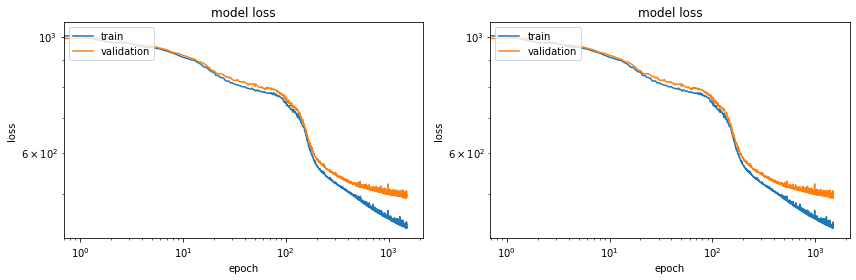

In [35]:
MODELS_TRAINED = False
BATCH_SIZE = 256
EPOCHS = 1500
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

if not MODELS_TRAINED:
    history = vae.fit(art_ae_train.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          validation_data = art_ae_val.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                 epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    vae.save(DATA_DIR + 'vae')
else:
    #load the model
    vae = tf.keras.models.load_model(DATA_DIR + 'vae')

    # Check its architecture
    vae.summary()

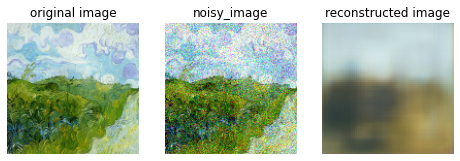

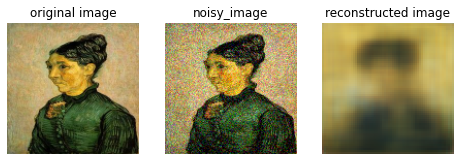

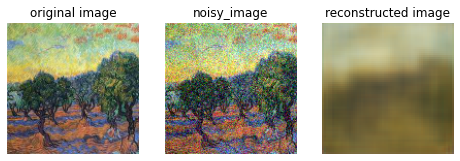

In [36]:
display_images(ds = art_ae_train, n_imgs = 3, model = vae  )

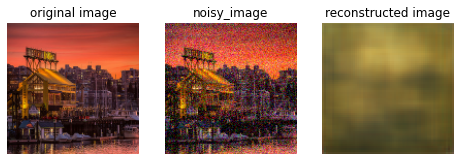

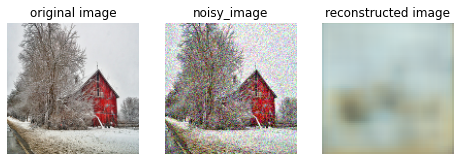

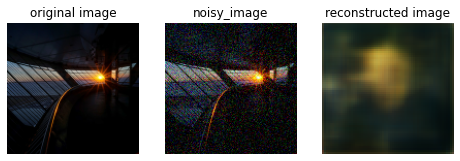

In [37]:
display_images(ds = pic_ae_train, n_imgs = 3, model = vae  )

As we can see, the variational auto-encoder is also very sensitive to the input.

<a id='cvae'></a>

## Conditional VAE

A CVAE is an example of a deep conditional generative model (CGM). We had no control over the types of data that could be output by a VAE. With a conditional variational auto-encoder we can by conditioning on another input c normally representing a category such as "art" or "painting".

$$\mathcal{L}=E[log P(X|z,c)] - D_{KL}[Q(z|X,c)||P(Z|c)]$$

what we had before:

$$\mathcal{L}=E[log P(X|z)] - D_{KL}[Q(z|X)||P(Z)]$$

ie the expectation of the reconstruction loss minus the kl_divergence.

In [38]:
def add_noise_with_label(x, label, sigma=0.05):
    x = tf.cast(x, dtype = tf.float32)
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)
    noise_img = tf.add(x, noise)
    
    return (noise_img, label), x

In [39]:
ds_cond_train = ds_train.map(add_noise_with_label).shuffle(ds_train.cardinality()).take(1000)
ds_cond_val = ds_test.map(add_noise_with_label).take(300)
ds_cond_test = ds_test.map(add_noise_with_label).skip(300)


In [40]:
ds_cond_test.cardinality(), ds_cond_val.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=351>,
 <tf.Tensor: shape=(), dtype=int64, numpy=300>)

In [77]:
def make_CVAE(activation, input_dim, embed_dim, Lambda, batch_size):
    """
    A convolutional auto-encoder encoder for an AE.
    
    Parameters
    ----------
        activation: string
            the activation function to use in the encoding
        input_shape: int tuple ex (128, 128, 3)
            the input shape of the image
        embed_dim: 
        Lambda:
            hyper-parameter that controls regularization of kl_divergence
        
    """
    act_down = {"activation" : activation, "strides": (2,2), 'padding' : 'SAME' }

    act_up = {"activation" : 'relu', 
              'kernel_size': (4,4), 
              "strides": (1,1), 
              'padding' : 'SAME' }
    upsamp_args = {'size' : (2,2), 'interpolation' : 'nearest'}

    flat_embed_dim = (np.prod(embed_dim),) 

    encoder = Sequential([
                Conv2D(4, kernel_size = (3,3), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(16,  kernel_size = (2,2), input_shape = input_dim, **act_down), #128/2 = 64
                Conv2D(64, kernel_size = (2,2), **act_down),  #64/2 ->32
                Dropout(0.05),
                ])
    decoder =  Sequential([
                Input(shape = embed_dim),
                #Dropout(0.1),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(64, **act_up),
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(16, **act_up), 
                layers.UpSampling2D(**upsamp_args), #64
                Conv2D(8, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(4, **act_up), 
                layers.UpSampling2D(**upsamp_args), #128
                Conv2D(3, activation = "sigmoid", 
                             kernel_size = (1,1), 
                             strides = (1,1),
                             padding = "SAME"),
                ])
                
    _input = Input(shape = input_dim)
    label_input = Input(shape = 1)
    encoder_output = encoder(_input)
    
    #begin embedding space
    flat = Flatten()(encoder_output)
    cat_embed_input = layers.concatenate([flat, label_input])
    x = Dense(flat_embed_dim[0], activation = "linear")(cat_embed_input)
    
    #################################################################
    #adapted directly from the keras documentation
    
    mu = layers.Dense(embed_dim[0], name="z_mean")(x)
    log_sigma = layers.Dense(embed_dim[0], name="z_log_var")(x)
    
    #sampling:
    batch, dim = tf.shape(mu)
    epsilon = tf.random.normal((batch, dim), mean = 0, stddev = 1)
    normal_draws = mu + tf.exp(0.5 * log_sigma) * epsilon
    
    z = layers.concatenate([normal_draws, label_input])
    ##################################################################
    
    x=Dense(flat_embed_dim[0], activation = "relu")(z)
    x=layers.Reshape(embed_dim)(x) #end embedding space
    
    output = decoder(x)

    cvae_model = models.Model(inputs = [_input, label_input], outputs = output)
    
    #BE CAREFUL: ON THE HOMEWORK YOU NEED TO CREATE YOUR OWN CUSTOM LAYER. 
    #THE LAMBDA Layer (the implimentation below) WILL NOT SUFFICE.
    kl_layer = layers.Lambda(analytical_kl)([log_sigma,mu])
    cvae_model.add_loss(kl_layer)
    cvae_model.compile(optimizer = Adam(learning_rate=1e-3), loss = reconstruction_loss)
    cvae_model.summary()
    
    
    return cvae_model


In [78]:
BATCH_SIZE = 256
HIDDEN_DIM = (4,4,64)
cvae = make_CVAE( activation = 'relu',
            input_dim = INPUT_SIZE, 
            embed_dim = HIDDEN_DIM,
            Lambda = 1.2,
            batch_size = BATCH_SIZE)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 16, 16, 64)   4544        input_16[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 16384)        0           sequential_12[0][0]              
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

Epoch 1/500
4/4 [==============================] - 10s 495ms/step - loss: 1958.4150 - val_loss: 1333.6824
Epoch 2/500
4/4 [==============================] - 10s 369ms/step - loss: 1287.3781 - val_loss: 1338.9316
Epoch 3/500
4/4 [==============================] - 10s 363ms/step - loss: 1280.8755 - val_loss: 1326.8158
Epoch 4/500
4/4 [==============================] - 10s 371ms/step - loss: 1274.9773 - val_loss: 1299.2867
Epoch 5/500
4/4 [==============================] - 10s 376ms/step - loss: 1239.3386 - val_loss: 1259.3396
Epoch 6/500
4/4 [==============================] - 10s 365ms/step - loss: 1215.0626 - val_loss: 1195.5571
Epoch 7/500
4/4 [==============================] - 10s 360ms/step - loss: 1104.8352 - val_loss: 1079.8160
Epoch 8/500
4/4 [==============================] - 10s 374ms/step - loss: 1010.2767 - val_loss: 968.5563
Epoch 9/500
4/4 [==============================] - 10s 365ms/step - loss: 957.4069 - val_loss: 942.3448
Epoch 10/500
4/4 [==============================]

INFO:tensorflow:Assets written to: data/cvae/assets


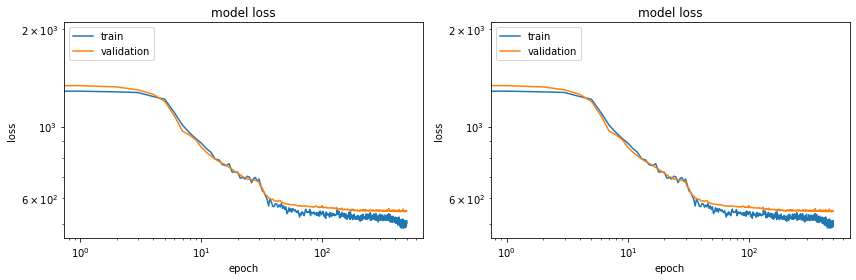

In [80]:
MODELS_TRAINED = False

EPOCHS = 500
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

if not MODELS_TRAINED:
    history = cvae.fit(ds_cond_train.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          validation_data = ds_cond_val.batch(BATCH_SIZE).prefetch(AUTOTUNE),
                          epochs=EPOCHS, callbacks = [es]#, mc]
        )
    plot_loss(history)
    
    #save the model
    cvae.save(DATA_DIR + 'cvae')
else:
    #load the model
    cvae = tf.keras.models.load_model(DATA_DIR + 'cvae', 
           custom_objects = {"reconstruction_loss" : reconstruction_loss})

    # Check its architecture
    cvae.summary()

In [81]:
np.arange(start = 0.0, stop = 1, step = 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

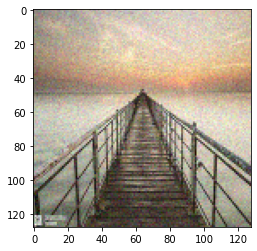

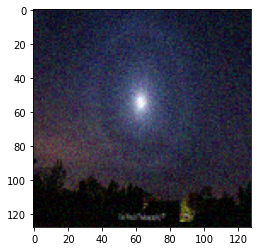

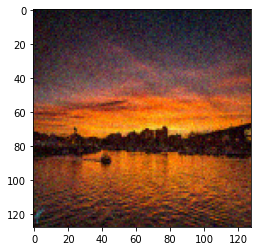

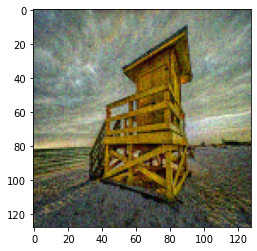

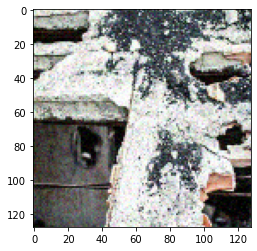

In [82]:
count = 0

#loop through the same five images
images = []
for i, (batch_input, imgs_to_reconstruct) in enumerate(ds_cond_test.take(5)):
    images.append(batch_input[0])
for img in images:
    plt.imshow(img)
    plt.show()

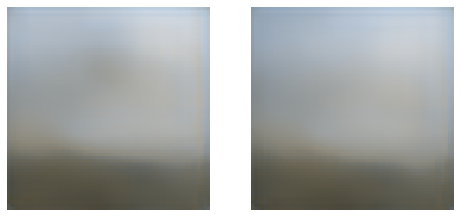

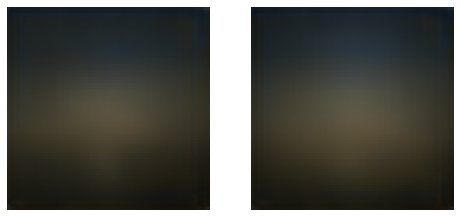

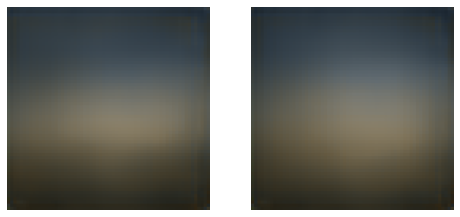

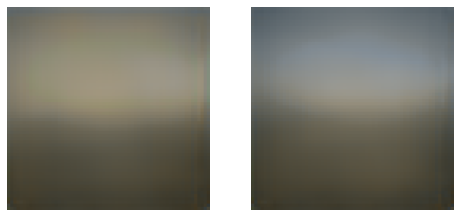

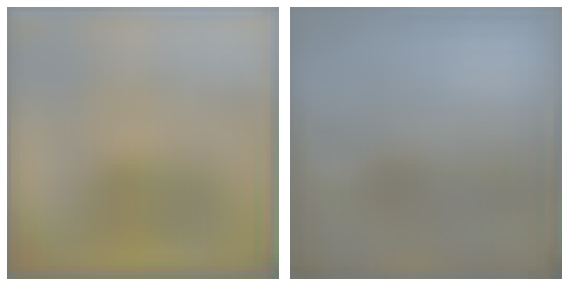

In [84]:
def get_prediction(img, label):
    input2predict = (tf.reshape(img, shape = (-1, 128,128,3)), 
                         tf.reshape( label, shape = (-1, 1)))
    prediction = cvae.predict(input2predict)
    return  tf.reshape( prediction, shape = (-1, 128, 3))


ax = ax.flatten()
count = 0
for img in images:
    #plt.imshow(img)
    fig, ax = plt.subplots(1, 2, figsize = (8,8))
    ax[0].imshow(get_prediction(img, 0))
    ax[1].imshow(get_prediction(img, 1))
    [ax[i].axis('off') for i in range(len(ax))];
plt.tight_layout()


### Further resources:

Auto-encoding Variational Bayes by Kingma et. al (2013)

https://arxiv.org/pdf/1312.6114.pdf

Stochastic Backpropagation and Approximate Inference in Deep Generative Models by
Rezende et. al

https://arxiv.org/abs/1401.4082

Three Blue One Brown youtube page for math intuition

https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw

A fun video about variational auto-encoders from 2018:

https://www.youtube.com/watch?v=9zKuYvjFFS8

<a id='bonus'></a>
# Bonus Material:

A very cool paper by Pavlos et al: https://arxiv.org/abs/1903.05071

## Bayesian Optimization:
<img src="https://research.fb.com/wp-content/uploads/2018/09/bo_1d_opt.gif">